## Hybrid Deep Learning Model : CNN & Transformer

> Student : Sasha Annabel (22/496780/PA/21361)

> Topic : Classifying xray medical images to decide whether person has pneumonia or not.

### Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


### Dataset Loader

In [ ]:
img_height, img_width = 224, 224  # Resize images to fit model input
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/sem5/deep learning/xray_dataset_covid19/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/sem5/deep learning/xray_dataset_covid19/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### Hybrid Model Build

In [ ]:
def build_hybrid_model(input_shape=(img_height, img_width, 3)):
    inputs = layers.Input(shape=input_shape)

    # CNN feature extractor
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and reshape for transformer input
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Reshape((8, 16))(x)  # Adjust based on the output shape of your CNN

    # Transformer encoder
    transformer_layer = layers.MultiHeadAttention(num_heads=2, key_dim=16)
    x = transformer_layer(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected for classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_hybrid_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### Training/Testing

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4956 - loss: 0.8509 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5697 - loss: 0.6921 - val_accuracy: 0.7000 - val_loss: 0.6881
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.6015 - loss: 0.6914 - val_accuracy: 0.9750 - val_loss: 0.6821
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.6941 - loss: 0.6835 - val_accuracy: 0.9750 - val_loss: 0.6507
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7014 - loss: 0.6654 - val_accuracy: 0.8250 - val_loss: 0.5759
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7130 - loss: 0.5901 - val_accuracy: 0.9750 - val_loss: 0.2970
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7386 - loss: 0.6071 - val_accuracy: 0.9250 - val_loss: 0.2470
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.7560 - loss: 0.5001 - val_accuracy: 0.9750 - val_loss: 0.3764
Epoch 9/10
5/5 ━━━━

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.8375 - loss: 0.3415
Test accuracy: 0.8500000238418579


### Saving Model

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/sem5/deep learning/pneumonia_hybrid_model.h5')
model.save('/content/pneumonia_hybrid_model.h5')
print("Model saved as 'pneumonia_hybrid_model.h5'")

Model saved as 'pneumonia_hybrid_model.h5'


### Function To Predict New Data

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, img_height=224, img_width=224):
    # Load the image with target size
    img = load_img(image_path, target_size=(img_height, img_width))
    # Convert the image to an array and scale pixel values
    img_array = img_to_array(img) / 255.0
    # Expand dimensions to create a batch of one image
    return np.expand_dims(img_array, axis=0), img

def predict_pneumonia(image_path, model_path='/content/pneumonia_hybrid_model.h5'):
    # Load the trained model
    model = load_model(model_path)
    # Preprocess the image
    preprocessed_image, original_image = preprocess_image(image_path)
    # Predict using the model
    prediction = model.predict(preprocessed_image)[0][0]

    # Display the image
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Analyzed Image")
    plt.show()

    # Interpret the prediction
    if prediction < 0.5:
        return f"Pneumonia detected (confidence: {prediction:.2f})"
    else:
        return f"No pneumonia detected (confidence: {1 - prediction:.2f})"


### Try New Data : POSITIVE PNEUMONIA

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


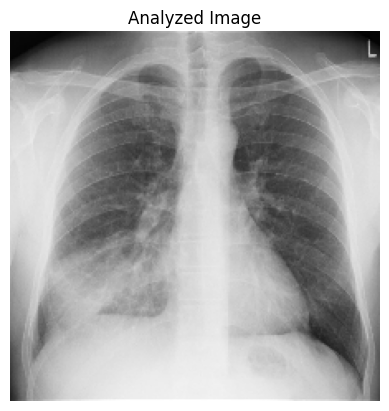

Pneumonia detected (confidence: 0.46)


In [ ]:
print(predict_pneumonia('/content/true-pneumonia.jpeg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


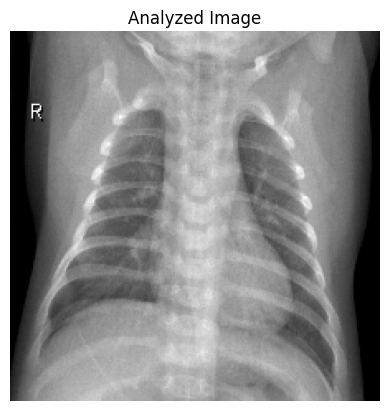

Pneumonia detected (confidence: 0.02)


In [ ]:
print(predict_pneumonia('/content/true-p-1.jpeg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


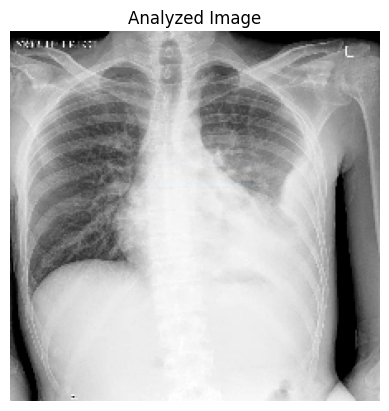

Pneumonia detected (confidence: 0.08)


In [ ]:
print(predict_pneumonia('/content/true-pneumonia-2.jpg'))

### Try New Data : NO PNEUMONIA (Normal)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


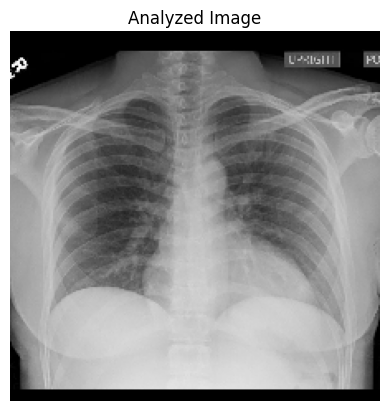

No pneumonia detected (confidence: 0.07)


In [ ]:
print(predict_pneumonia('/content/normal.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


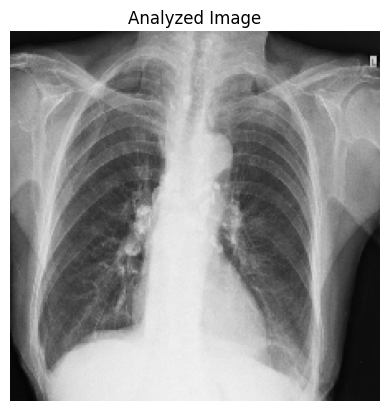

Pneumonia detected (confidence: 0.17)


In [ ]:
print(predict_pneumonia('/content/tuberculosis.jpeg'))